In [ ]:
!pip install ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=1101eeabf111b74f2e78d0e7bb22bf73851a9346884d02b8e6d832a8eb308e8a
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
!pip install tabulate


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.volatility import BollingerBands
from ta.trend import SMAIndicator
from tabulate import tabulate

# Pengumpulan data
ticker = 'BMRI.JK'
data = yf.download(ticker, start='2022-06-01', end='2024-06-01')
data = data[['Close', 'Volume']].copy()  # Membuat salinan independen dari DataFrame
data.reset_index(inplace=True)

# Cek missing values
data.interpolate(method='linear', inplace=True)
data.dropna(inplace=True)

# Hitung return logaritmik harian
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# Hitung indikator teknikal
bb = BollingerBands(close=data['Close'], window=20, window_dev=2)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()
data['SMA'] = SMAIndicator(close=data['Close'], window=20).sma_indicator()
data.dropna(inplace=True)

# Tampilkan beberapa baris dari data menggunakan tabulate
print(tabulate(data.head(), headers='keys', tablefmt='psql'))


[*********************100%%**********************]  1 of 1 completed

+----+---------------------+---------+-----------+-------------+-----------+----------+---------+
|    | Date                |   Close |    Volume |   LogReturn |   BB_High |   BB_Low |     SMA |
|----+---------------------+---------+-----------+-------------+-----------+----------+---------|
| 20 | 2022-06-30 00:00:00 |  3962.5 | 125507600 | -0.00314961 |   4229.92 |  3971.33 | 4100.62 |
| 21 | 2022-07-01 00:00:00 |  3800   | 191672200 | -0.0418741  |   4269.72 |  3901.53 | 4085.62 |
| 22 | 2022-07-04 00:00:00 |  3700   | 246417000 | -0.0266682  |   4316.28 |  3817.47 | 4066.88 |
| 23 | 2022-07-05 00:00:00 |  3825   |  90919800 |  0.0332256  |   4317.96 |  3783.29 | 4050.62 |
| 24 | 2022-07-06 00:00:00 |  3762.5 | 180812800 | -0.0164748  |   4314.57 |  3742.93 | 4028.75 |
+----+---------------------+---------+-----------+-------------+-----------+----------+---------+


In [ ]:
from sklearn.model_selection import train_test_split

X = data[['Close', 'Volume', 'BB_High', 'BB_Low', 'SMA']].values
y = data['LogReturn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}, R-squared: {r2}')


MSE: 0.00029407203585725, R-squared: -0.25686951592227847


In [ ]:
def gbm_simulation(S0, mu, sigma, T, dt, N):
    t = np.linspace(0, T, int(T/dt))
    W = np.random.standard_normal(size=int(T/dt))
    W = np.cumsum(W)*np.sqrt(dt)
    X = (mu-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X)
    return S
predicted_mu = model.predict(X_test)  # Prediksi drift untuk data uji
sigma = np.std(data['LogReturn'])  # Volatilitas dari return logaritmik

S0 = data['Close'].iloc[-1]  # Harga penutupan terakhir sebagai S0
T = 1  # Misal 1 tahun
dt = 1/252  # Asumsi 252 hari perdagangan dalam setahun
N = 1000  # Jumlah simulasi

simulations = np.zeros((N, int(T/dt)))

for i in range(N):
    simulations[i] = gbm_simulation(S0, predicted_mu.mean(), sigma, T, dt, N)



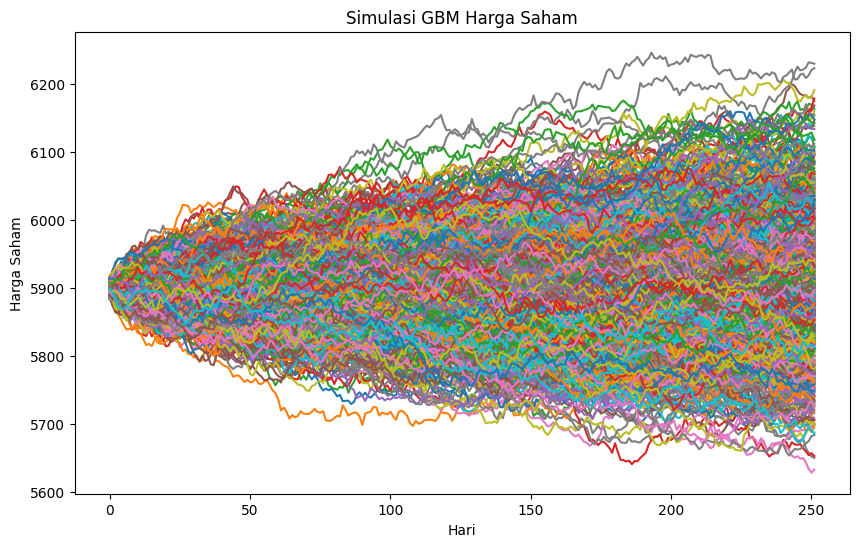

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for i in range(N):
    plt.plot(simulations[i])
plt.title('Simulasi GBM Harga Saham')
plt.xlabel('Hari')
plt.ylabel('Harga Saham')
plt.show()
